1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

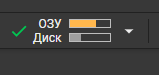


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


### Импорт библиотек

In [ ]:
# Для работы с файлами
import os

# Для работы со временем
import time

# Для работы с арихивами
import zipfile

# загрузка файлов по HTML ссылке
import gdown

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку numpy
import numpy as np

# Импортируем стандартные слои keras
from tensorflow.keras.layers import (
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Input,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
)

# Импортируем модели keras: Model
from tensorflow.keras.models import Model

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака
if not os.path.exists("construction_256x192.zip"):
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip",
        None,
        quiet=False,
    )

# распоковываем архив
if not os.path.exists("train") or not os.path.exists("val"):
    with zipfile.ZipFile("construction_256x192.zip", "r") as zip_ref:
        zip_ref.extractall()


## Решение

### Задание констант

In [10]:
# Ваше решение
IMG_WIDTH = 256  # Ширина картинки
IMG_HEIGHT = 192  # Высота картинки
CLASS_COUNT = 7  # Изменено количество классов на 7
TRAIN_DIRECTORY = "train"  # Название папки с файлами обучающей выборки
VAL_DIRECTORY = "val"  # Название папки с файлами проверочной выборки

### Загрузка данных

In [11]:
def load_imageset(folder, subset, title):
    image_list = []
    cur_time = time.time()
    for filename in sorted(os.listdir(f"{folder}/{subset}")):
        image_list.append(
            image.load_img(
                os.path.join(f"{folder}/{subset}", filename),
                target_size=(IMG_HEIGHT, IMG_WIDTH),
            )
        )
    print(
        "{} выборка загружена. Время загрузки: {:.2f} с".format(
            title, time.time() - cur_time
        )
    )
    print("Количество изображений:", len(image_list))
    return image_list


In [12]:
train_images = load_imageset(TRAIN_DIRECTORY, "original", "Обучающая")
val_images = load_imageset(VAL_DIRECTORY, "original", "Проверочная")
train_segments = load_imageset(TRAIN_DIRECTORY, "segment", "Обучающая")
val_segments = load_imageset(VAL_DIRECTORY, "segment", "Проверочная")

Обучающая выборка загружена. Время загрузки: 0.20 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100
Обучающая выборка загружена. Время загрузки: 0.19 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100


### Задание констант

In [ ]:
CLASS_LABELS_16 = (
    (100, 100, 100),  # Пол (серый)
    (0, 0, 100),  # Потолок (синий)
    (0, 100, 0),  # Стена (зеленый)
    (100, 0, 0),  # Колонна (красный)
    (0, 100, 100),  # Проем (темно-бирюзовый)
    (100, 0, 100),  # Дверь (бордовый)
    (100, 100, 0),  # Окно (золотой)
    (200, 200, 200),  # Внешний мир (светло-серый)
    (0, 200, 0),  # Перила (светло-зеленый)
    (200, 0, 0),  # Батареи (светло-красный)
    (0, 200, 200),  # Люди (бирюзовый)
    (0, 0, 200),  # Лестница (светло-синий)
    (200, 0, 200),  # Инвентарь (розовый)
    (200, 200, 0),  # Лампа (желтый)
    (0, 100, 200),  # Провод (голубой)
    (100, 0, 200),  # Балка (фиолетовый)
)
# Классы для 7 классов
LABELS_7_CLASS = (0, 1, 2, 4, 3, 3, 3, 6, 4, 6, 6, 4, 5, 6, 6, 6)
FLOOR_COLOR = (100, 100, 100)  # Цвет пола (серый)
CEILING_COLOR = (0, 0, 100)  # Цвет потолка (синий)
WALL_COLOR = (0, 100, 0)  # Цвет стены (зеленый)
APERTURE_DOOR_WINDOW_COLOR = (0, 100, 100)  # Цвет проема (темно-бирюзовый)
COLUMN_RAILINGS_LADDER_COLOR = (100, 0, 0)  # Цвет колонны, перил и лестницы (красный)
INVENTORY_COLOR = (200, 0, 200)  # Цвет инвентаря (розовый)
MISC_COLOR = (200, 200, 200)  # Цвет внешнего мира (светло-серый)

CLASS_LABELS_7 = (
    FLOOR_COLOR,
    CEILING_COLOR,
    WALL_COLOR,
    APERTURE_DOOR_WINDOW_COLOR,
    COLUMN_RAILINGS_LADDER_COLOR,
    INVENTORY_COLOR,
    MISC_COLOR,
)


In [ ]:
def rgb_to_labels_7(
    image_list, class_labels=CLASS_LABELS_16, new_labels=CLASS_LABELS_7
):
    # Преобразует RGB-картинки сегментации в метки классов (7 классов)
    result = []
    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype="uint8")

        for i, cl in enumerate(class_labels):
            # Находим пиксели с цветом cl и присваиваем им новый класс
            y[np.where(np.all(sample == class_labels[i], axis=-1))] = new_labels[i]
        result.append(y)
    return np.array(result)


def labels_7_to_rgb(image_list):
    # Преобразует метки классов обратно в RGB-картинки (7 цветов)
    result = []
    for y in image_list:
        temp = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
        for i, cl in enumerate(CLASS_LABELS_7):
            # Находим пиксели с меткой i и присваиваем им цвет из CLASS_LABELS_7
            temp[np.where(np.all(y == i, axis=-1))] = CLASS_LABELS_7[i]
        result.append(temp)
    return np.array(result)


### Подготовка выборок

In [ ]:
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])

y_train = rgb_to_labels_7(train_segments, CLASS_LABELS_16, LABELS_7_CLASS)
y_val = rgb_to_labels_7(val_segments, CLASS_LABELS_16, LABELS_7_CLASS)

print("Форма x_train:", x_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_val:", y_val.shape)


Форма x_train: (1900, 192, 256, 3)
Форма x_val: (100, 192, 256, 3)
Форма y_train: (1900, 192, 256, 1)
Форма y_val: (100, 192, 256, 1)


### Функция вывода примеров работы модели

In [23]:
def process_images(model, count=1):
    indexes = np.random.randint(0, len(x_val), count)
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_7_to_rgb(predict[..., None])

    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    if count == 1:
        axs[0].set_title("Результат работы модели:")
        axs[0].imshow(orig[0])
        axs[0].axis("off")

        axs[1].set_title("Оригинальное сегментированное")
        axs[1].imshow(val_segments[indexes[0]])
        axs[1].axis("off")

        axs[2].set_title("Оригинальное изображение")
        axs[2].imshow(val_images[indexes[0]])
        axs[2].axis("off")
    else:
        for i in range(count):
            axs[0, 0].set_title("Результат работы модели:")
            axs[0, i].imshow(orig[i])
            axs[0, i].axis("off")

            axs[1, 0].set_title("Оригинальное сегментированное")
            axs[1, i].imshow(val_segments[indexes[i]])
            axs[1, i].axis("off")

            axs[2, 0].set_title("Оригинальное изображение")
            axs[2, i].imshow(val_images[indexes[i]])
            axs[2, i].axis("off")
    plt.show()

### Создание и обучение модели pspnet

In [ ]:
def pspnet(CLASS_COUNT, input_shape):
    # Входной слой
    img_input = Input(input_shape)

    # Первый блок свертки
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 1/2

    # Второй блок свертки
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 1/4

    # Третий блок свертки
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Карта признаков
    feature_map = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Размеры карты признаков
    fm_h, fm_w, fm_c = feature_map.shape[1:]

    # Целевые размеры пулинга для пирамиды
    target_output_sizes = [(1, 1), (2, 2), (4, 4), (8, 8)]

    # Создаем список для пирамиды признаков
    pyramid_features = [feature_map]

    for th, tw in target_output_sizes:
        # Проверяем, что размеры карты признаков делятся нацело на целевые размеры пулинга
        if fm_h % th == 0 and fm_w % tw == 0:
            pool_h = fm_h // th
            pool_w = fm_w // tw
        else:
            print(
                f"Предупреждение: Размеры карты признаков ({fm_h}x{fm_w}) "
                f"не делятся нацело на целевой размер пулинга ({th}x{tw}). "
                "Пропускаем этот масштаб."
            )
            continue
        # Применяем AveragePooling2D с целевыми размерами
        pooled = AveragePooling2D(pool_size=(pool_h, pool_w), strides=(pool_h, pool_w))(
            feature_map
        )
        # Уменьшаем количество каналов в пулинге
        pooled = Conv2D(
            fm_c // len(target_output_sizes), (1, 1), activation="relu", padding="same"
        )(pooled)
        # Увеличиваем размер пулинга до размера карты признаков
        upsample_factor_h = fm_h // pooled.shape[1]
        upsample_factor_w = fm_w // pooled.shape[2]
        upsampled = UpSampling2D(
            size=(upsample_factor_h, upsample_factor_w), interpolation="bilinear"
        )(pooled)
        pyramid_features.append(upsampled)
    # Объединяем все пирамидальные признаки
    x = concatenate(pyramid_features)

    # Первый блок декодирования
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Второй блок декодирования
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Третий блок декодирования
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Четвертый блок декодирования
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Выходной слой
    x = Conv2D(CLASS_COUNT, (1, 1), activation="softmax", padding="same")(x)

    model = Model(img_input, x)  # Создаем модель
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )  # Компилируем модель
    return model


In [ ]:
# Создаем модель pspnet для 7 классов
model_pspnet = pspnet(CLASS_COUNT, (IMG_HEIGHT, IMG_WIDTH, 3))
model_pspnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 192, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 192, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 96, 128,   │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 96, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 48, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 48, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 48, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_17[0][0] 

 Total params: 3,375,239 (12.88 MB)

 Trainable params: 3,371,975 (12.86 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [ ]:
history = model_pspnet.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1,
) # Обучаем модель


Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 1.6923 - sparse_categorical_accuracy: 0.4383 - val_loss: 1.5232 - val_sparse_categorical_accuracy: 0.4951
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.6686 - val_loss: 1.1885 - val_sparse_categorical_accuracy: 0.6026
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.9510 - sparse_categorical_accuracy: 0.7278 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.6208
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.8753 - sparse_categorical_accuracy: 0.7429 - val_loss: 1.0740 - val_sparse_categorical_accuracy: 0.6492
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.7605 - sparse_categorical_accuracy: 0.7711 - val_loss: 1.0574 - val_sparse_categorical_accuracy: 0.6581
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.7823 - val_loss: 1.0566 - val_sparse_categorical_accurac

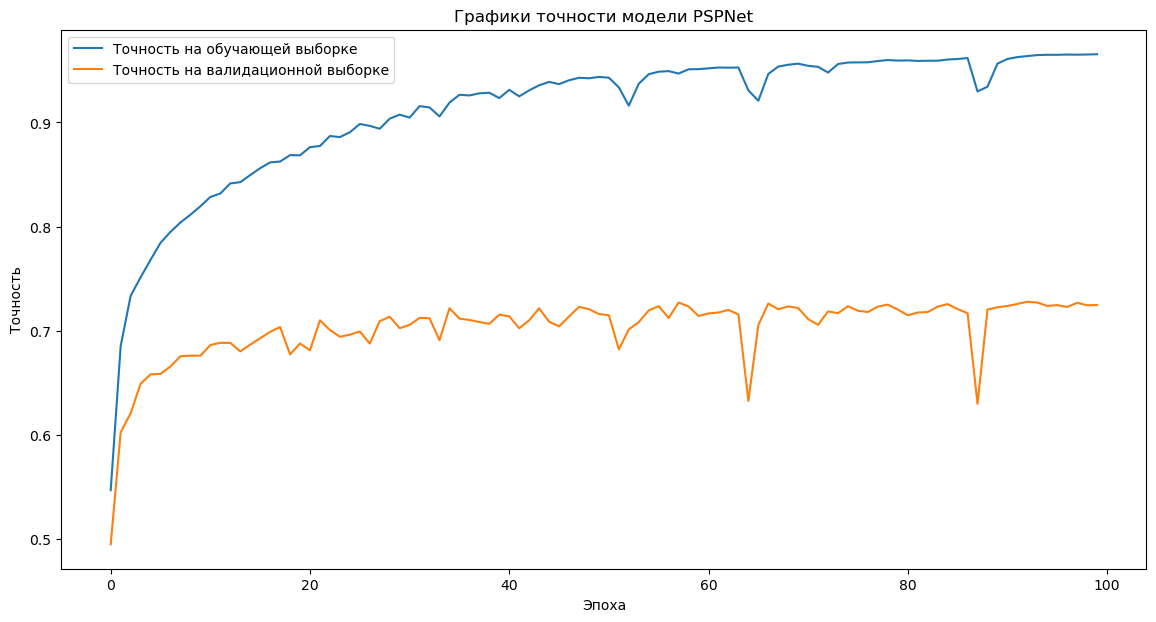

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(
    history.history["sparse_categorical_accuracy"],
    label="Точность на обучающей выборке",
)
plt.plot(
    history.history["val_sparse_categorical_accuracy"],
    label="Точность на валидационной выборке",
)
plt.title("Графики точности модели PSPNet")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.show()


### Проверка модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


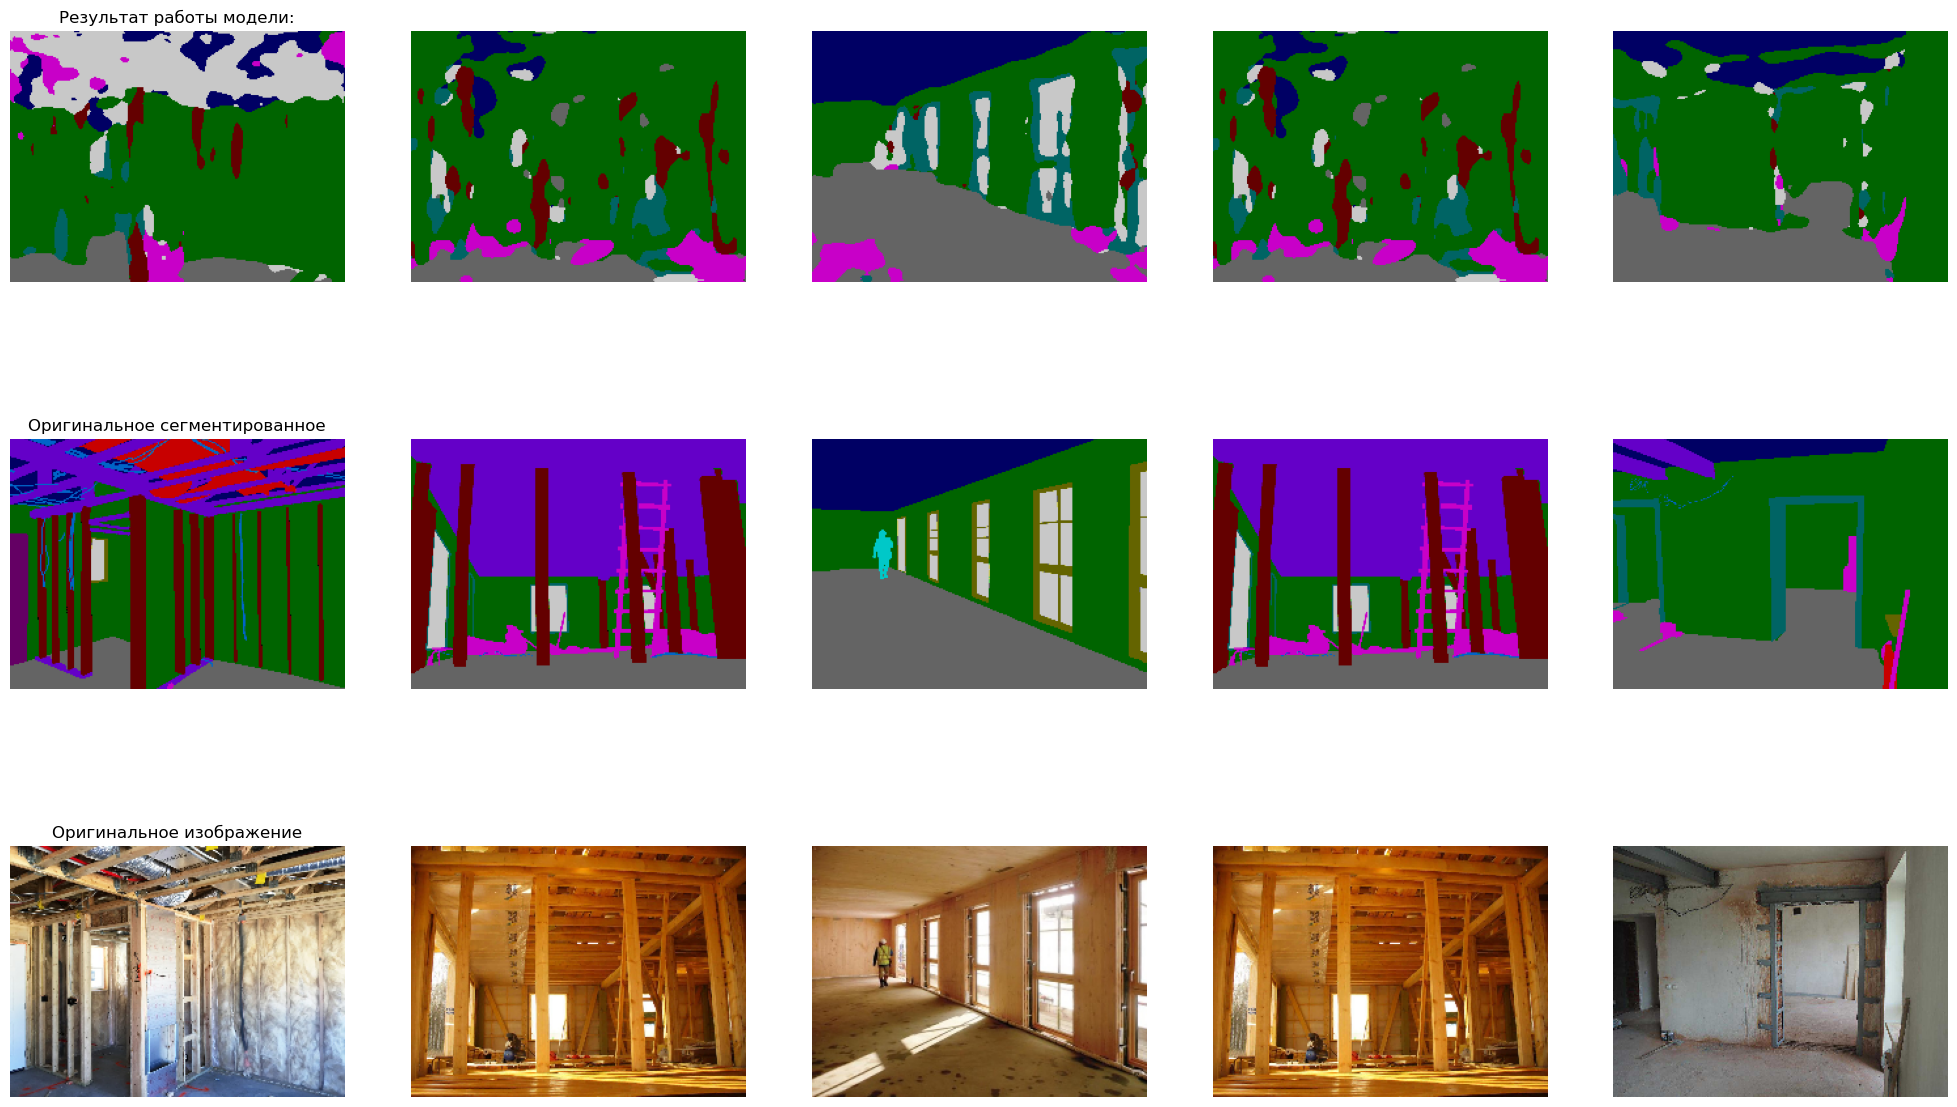

In [25]:
process_images(model_pspnet, 5)